# Evaluation

In [21]:
import csv
import json
import subprocess
import os
import timeit
from collections import defaultdict
import polars as pl

In [22]:
with open('../2-pattern-extraction/pattern_occurrences.csv', 'r') as f:
    reader = csv.DictReader(f)
    occurrences = {}
    for row in reader:
        if row['pattern'] not in occurrences:
            occurrences[row['pattern']] = []
        occurrences[row['pattern']].append(row['url'])

with open('../1-coding/diffs.json', 'r') as f:
    diffs = json.load(f)
    filenames = {
        d['url']: [
            f['filename'] for f in d['files']
        ]
        for d in diffs
    }

## Checkov

In [23]:
CHECKOV_CHECKS = {
    'Object storage lifecycle rules': [
        'CKV2_AWS_61',
    ],
    'AWS - Expensive DynamoDB': [
        'CKV_AWS_801',
        'CKV_AWS_802',
        'CKV_AWS_803',
    ],
    'Old generation': [
        'CKV_AWS_804',
    ],
}
CHECKOV_CHECKS_PARAM = ','.join(','.join(checks) for checks in CHECKOV_CHECKS.values())
CHECKOV_PATTERNS = {
    check: pattern
    for pattern, checks in CHECKOV_CHECKS.items()
    for check in checks
}

checkov_stats = []

for pattern, occs in occurrences.items():
    if pattern not in CHECKOV_CHECKS.keys():
        continue

    for url in occs:
        print(f'- {pattern}: {url}')

        _, _, _, owner, name, _, sha = url.split('/')

        snapshot_path = f'snapshots/{owner}-{name}-{sha}'

        summary = {
            'pattern': pattern,
            'url': url,
            'before': []
        }

        for version in os.listdir(snapshot_path):
            version_path = f'{snapshot_path}/{version}/'

            print(f'  * Running checkov against {version}')

            start = timeit.default_timer()

            result = subprocess.run([
                'checkov',
                '--evaluate-variables', 'true',
                '--download-external-modules', 'true',
                '--external-modules-download-path', '/tmp/',
                '--directory', version_path,
                '--check', CHECKOV_CHECKS_PARAM,
                '-o', 'json',
                '--framework', 'terraform',
            ], capture_output=True, encoding='utf-8')

            end = timeit.default_timer()

            stdout = json.loads(result.stdout)

            if 'results' not in stdout or 'summary' not in stdout:
                print('    NO RESULTS:', stdout)
                matched_patterns = []
                has_errors = False
            else:
                failed_checks = stdout['results']['failed_checks']
                matched_patterns = list(set(CHECKOV_PATTERNS[check['check_id']] for check in failed_checks))
                has_errors = stdout['summary']['parsing_errors'] != 0

            if version == 'after':
                summary['after'] = {
                    'matched': matched_patterns,
                    'errors': has_errors,
                    'duration': end - start,
                }
            else:
                summary['before'].append({
                    'matched': matched_patterns,
                    'errors': has_errors,
                    'duration': end - start,
                })

            print(f'    Done after {end - start:.2f}s')

        checkov_stats.append(summary)


- Object storage lifecycle rules: https://github.com/alphagov/govuk-aws/commit/f844cd8e254b161bebef04101f8ce177bcd0840c
  * Running checkov against after
    Done after 33.87s
  * Running checkov against before-f9fc11443ab8926b0761fb890974cd7169f9235f
    Done after 32.53s
- Object storage lifecycle rules: https://github.com/alphagov/govuk-terraform-provisioning/commit/ac105ab0a5ae38fbf69167e072f8970a4a61c3e8
  * Running checkov against after
    Done after 3.88s
  * Running checkov against before-c167e29c9d5867b897bd035315341d14fff84f29
    Done after 3.85s
- Object storage lifecycle rules: https://github.com/ExpediaGroup/apiary-data-lake/commit/47e62f2fc73a96611606cd619c084d1ded9d844d
  * Running checkov against after
    Done after 3.96s
  * Running checkov against before-f3c3068c66185f51ba97ed71a14ffdbea2a698b1
    Done after 3.94s
- Object storage lifecycle rules: https://github.com/SamTowne/BasketballDrillBot/commit/4ec6d54e4d36ab02b0a7daf042e727717371eaec
  * Running checkov aga

In [24]:
checkov_df = pl.DataFrame(checkov_stats)

with pl.Config(tbl_rows=150, tbl_width_chars=500):
    print(checkov_df)

checkov_df.write_json('results_checkov_2.json', row_oriented=True)

shape: (65, 4)
┌────────────────────────────────┬─────────────────────────────────┬─────────────────────────────────┬─────────────────────────────────┐
│ pattern                        ┆ url                             ┆ before                          ┆ after                           │
│ ---                            ┆ ---                             ┆ ---                             ┆ ---                             │
│ str                            ┆ str                             ┆ list[struct[3]]                 ┆ struct[3]                       │
╞════════════════════════════════╪═════════════════════════════════╪═════════════════════════════════╪═════════════════════════════════╡
│ Object storage lifecycle rules ┆ https://github.com/alphagov/go… ┆ [{["Object storage lifecycle r… ┆ {["Object storage lifecycle ru… │
│ Object storage lifecycle rules ┆ https://github.com/alphagov/go… ┆ [{["Object storage lifecycle r… ┆ {["Object storage lifecycle ru… │
│ Object storage lifecycle

## TFLint

In [25]:
TFLINT_RULES = {
    'Budget': 'cost_aws_budget',
    'Object storage lifecycle rules': 'cost_aws_object_storage_lifecycle_rule',
    'Old generation': 'cost_aws_old_generation',
    'AWS - Expensive DynamoDB': 'cost_aws_expensive_dynamodb',
}
TFLINT_PATTERNS = {
    rule: pattern
    for pattern, rule in TFLINT_RULES.items()
}
TFLINT_RULES_PARAMS = [f'--only={rule}' for rule in TFLINT_RULES.values()]

tflint_stats = []

for pattern, occs in occurrences.items():
    if pattern not in TFLINT_RULES.keys():
        continue

    for url in occs:
        print(f'- {pattern}: {url}')

        _, _, _, owner, name, _, sha = url.split('/')

        snapshot_path = f'snapshots/{owner}-{name}-{sha}'

        summary = {
            'pattern': pattern,
            'url': url,
            'before': []
        }

        for version in os.listdir(snapshot_path):
            version_path = f'{snapshot_path}/{version}/'

            print(f'  * Running tflint against {version}')

            print('    terraform get')

            terraform_result = subprocess.run(['terraform', f'-chdir={version_path}', 'get'], capture_output=True, encoding='utf-8')

            print(f'    terraform get returned with status {terraform_result.returncode}')

            print('    Starting tflint')

            start = timeit.default_timer()

            result = subprocess.run([
                'tflint',
                '--format=json',
                '--call-module-type=all',
                '--enable-plugin=cost',
                *TFLINT_RULES_PARAMS,
                f'--recursive'
            ], capture_output=True, encoding='utf-8', cwd=version_path)

            end = timeit.default_timer()

            stdout = json.loads(result.stdout)
            issues = stdout['issues']
            matched_patterns = [TFLINT_PATTERNS[issue['rule']['name']] for issue in issues]
            has_errors = len(stdout['errors']) != 0

            if version == 'after':
                summary['after'] = {
                    'matched': matched_patterns,
                    'errors': has_errors,
                    'duration': end - start,
                }
            else:
                summary['before'].append({
                    'matched': matched_patterns,
                    'errors': has_errors,
                    'duration': end - start,
                })

        tflint_stats.append(summary)

- Budget: https://github.com/AJarombek/global-aws-infrastructure/commit/4a89f4b8235961275fa0e6aaf20848f2b8b7e733
  * Running tflint against after
    terraform get
    terraform get returned with status 0
    Starting tflint
  * Running tflint against before-d79ab7eb96ba8d1bd6600ad116d024c124967e3a
    terraform get
    terraform get returned with status 0
    Starting tflint
- Budget: https://github.com/MartinFeineis/terraform/commit/359ba426393c78b78695797f9bdd6a08c0455720
  * Running tflint against after
    terraform get
    terraform get returned with status 0
    Starting tflint
  * Running tflint against before-a78936b97d7c08b1f82e01361ba27def21aa8f00
    terraform get
    terraform get returned with status 0
    Starting tflint
- Budget: https://github.com/stuartellis/stuartellis-org-tf-modules/commit/39a9cabac6765c75591ba258fef0d10ba7ae0f9e
  * Running tflint against after
    terraform get
    terraform get returned with status 0
    Starting tflint
  * Running tflint against

In [26]:
tflint_df = pl.DataFrame(tflint_stats)

with pl.Config(tbl_rows=150, tbl_width_chars=500):
    print(tflint_df)

tflint_df.write_json('results_tflint_2.json', row_oriented=True)

shape: (92, 4)
┌────────────────────────────────┬─────────────────────────────────┬─────────────────────────────────┬─────────────────────────────────┐
│ pattern                        ┆ url                             ┆ before                          ┆ after                           │
│ ---                            ┆ ---                             ┆ ---                             ┆ ---                             │
│ str                            ┆ str                             ┆ list[struct[3]]                 ┆ struct[3]                       │
╞════════════════════════════════╪═════════════════════════════════╪═════════════════════════════════╪═════════════════════════════════╡
│ Budget                         ┆ https://github.com/AJarombek/g… ┆ [{["Budget", "Object storage l… ┆ {["Budget", "Object storage li… │
│ Budget                         ┆ https://github.com/MartinFeine… ┆ [{["Budget", "Object storage l… ┆ {["Budget", "Object storage li… │
│ Budget                  

## Precision/recall

In [39]:
print(checkov_df.group_by('pattern').len())
print(tflint_df.group_by('pattern').len())

shape: (3, 2)
┌────────────────────────────────┬─────┐
│ pattern                        ┆ len │
│ ---                            ┆ --- │
│ str                            ┆ u32 │
╞════════════════════════════════╪═════╡
│ Object storage lifecycle rules ┆ 6   │
│ AWS - Expensive DynamoDB       ┆ 25  │
│ Old generation                 ┆ 34  │
└────────────────────────────────┴─────┘
shape: (4, 2)
┌────────────────────────────────┬─────┐
│ pattern                        ┆ len │
│ ---                            ┆ --- │
│ str                            ┆ u32 │
╞════════════════════════════════╪═════╡
│ Budget                         ┆ 27  │
│ AWS - Expensive DynamoDB       ┆ 25  │
│ Object storage lifecycle rules ┆ 6   │
│ Old generation                 ┆ 34  │
└────────────────────────────────┴─────┘


### Checkov

#### Before

In [27]:
checkov_clean = checkov_df.filter([
        pl.col('before').list.len() != 0,
        pl.col('before').list.get(0).struct.field('errors').not_(),
        pl.col('after').struct.field('errors').not_(),
    ])

tp = defaultdict(int)
fp = defaultdict(int)
fn = defaultdict(int)

for real_pattern, _, before, _ in checkov_clean.iter_rows():
    matched_patterns = before[0]['matched']

    for pat in CHECKOV_CHECKS.keys():
        if pat == real_pattern and pat in matched_patterns:
            tp[pat] += 1
        if pat != real_pattern and pat in matched_patterns:
            fp[pat] += 1
        if pat == real_pattern and pat not in matched_patterns:
            fn[pat] += 1

pr = []
for pat in CHECKOV_CHECKS.keys():
    pr.append({
        'pattern': pat,
        'precision': tp[pat] / (tp[pat] + fp[pat]),
        'recall': tp[pat] / (tp[pat] + fn[pat]),
    })

print(pl.DataFrame(pr))

shape: (3, 3)
┌────────────────────────────────┬───────────┬──────────┐
│ pattern                        ┆ precision ┆ recall   │
│ ---                            ┆ ---       ┆ ---      │
│ str                            ┆ f64       ┆ f64      │
╞════════════════════════════════╪═══════════╪══════════╡
│ Object storage lifecycle rules ┆ 0.12      ┆ 1.0      │
│ AWS - Expensive DynamoDB       ┆ 0.913043  ┆ 1.0      │
│ Old generation                 ┆ 0.833333  ┆ 0.555556 │
└────────────────────────────────┴───────────┴──────────┘


#### Before + after

In [28]:
tp = defaultdict(int)
fp = defaultdict(int)
fn = defaultdict(int)

for real_pattern, _, before, after in checkov_clean.iter_rows():
    matched_before = before[0]['matched']
    matched_after = after['matched']

    for pat in CHECKOV_CHECKS.keys():
        if pat == real_pattern and pat in matched_before:
            tp[pat] += 1
        if pat != real_pattern and pat in matched_before:
            fp[pat] += 1
        if pat == real_pattern and pat not in matched_before:
            fn[pat] += 1

        if pat in matched_after:
            fp[pat] += 1

pr = []
for pat in CHECKOV_CHECKS.keys():
    pr.append({
        'pattern': pat,
        'precision': tp[pat] / (tp[pat] + fp[pat]),
        'recall': tp[pat] / (tp[pat] + fn[pat]),
    })

print(pl.DataFrame(pr))

shape: (3, 3)
┌────────────────────────────────┬───────────┬──────────┐
│ pattern                        ┆ precision ┆ recall   │
│ ---                            ┆ ---       ┆ ---      │
│ str                            ┆ f64       ┆ f64      │
╞════════════════════════════════╪═══════════╪══════════╡
│ Object storage lifecycle rules ┆ 0.06383   ┆ 1.0      │
│ AWS - Expensive DynamoDB       ┆ 0.636364  ┆ 1.0      │
│ Old generation                 ┆ 0.5       ┆ 0.555556 │
└────────────────────────────────┴───────────┴──────────┘


### TFLint

#### Before

In [29]:
tflint_clean = tflint_df.filter([
        pl.col('before').list.len() != 0,
        pl.col('before').list.get(0).struct.field('errors').not_(),
        pl.col('after').struct.field('errors').not_(),
    ])

tp = defaultdict(int)
fp = defaultdict(int)
fn = defaultdict(int)

for real_pattern, _, before, after in tflint_clean.iter_rows():
    matched_before = before[0]['matched']
    matched_after = after['matched']

    for pat in TFLINT_RULES.keys():
        if pat == real_pattern and pat in matched_before:
            tp[pat] += 1
        if pat != real_pattern and pat in matched_before:
            fp[pat] += 1
        if pat == real_pattern and pat not in matched_before:
            fn[pat] += 1

pr = []
for pat in TFLINT_RULES.keys():
    pr.append({
        'pattern': pat,
        'precision': tp[pat] / (tp[pat] + fp[pat]),
        'recall': tp[pat] / (tp[pat] + fn[pat]),
    })

print(pl.DataFrame(pr))

shape: (4, 3)
┌────────────────────────────────┬───────────┬──────────┐
│ pattern                        ┆ precision ┆ recall   │
│ ---                            ┆ ---       ┆ ---      │
│ str                            ┆ f64       ┆ f64      │
╞════════════════════════════════╪═══════════╪══════════╡
│ Budget                         ┆ 0.3       ┆ 0.4      │
│ Object storage lifecycle rules ┆ 0.153846  ┆ 1.0      │
│ Old generation                 ┆ 0.625     ┆ 0.555556 │
│ AWS - Expensive DynamoDB       ┆ 1.0       ┆ 0.928571 │
└────────────────────────────────┴───────────┴──────────┘


#### Before + after

In [30]:
tp = defaultdict(int)
fp = defaultdict(int)
fn = defaultdict(int)

for real_pattern, _, before, after in tflint_clean.iter_rows():
    matched_before = before[0]['matched']
    matched_after = after['matched']

    for pat in TFLINT_RULES.keys():
        if pat == real_pattern and pat in matched_before:
            tp[pat] += 1
        if pat != real_pattern and pat in matched_before:
            fp[pat] += 1
        if pat == real_pattern and pat not in matched_before:
            fn[pat] += 1

        if pat in matched_after:
            fp[pat] += 1

pr = []
for pat in TFLINT_RULES.keys():
    pr.append({
        'pattern': pat,
        'precision': tp[pat] / (tp[pat] + fp[pat]),
        'recall': tp[pat] / (tp[pat] + fn[pat]),
    })

print(pl.DataFrame(pr))

shape: (4, 3)
┌────────────────────────────────┬───────────┬──────────┐
│ pattern                        ┆ precision ┆ recall   │
│ ---                            ┆ ---       ┆ ---      │
│ str                            ┆ f64       ┆ f64      │
╞════════════════════════════════╪═══════════╪══════════╡
│ Budget                         ┆ 0.146341  ┆ 0.4      │
│ Object storage lifecycle rules ┆ 0.083333  ┆ 1.0      │
│ Old generation                 ┆ 0.357143  ┆ 0.555556 │
│ AWS - Expensive DynamoDB       ┆ 0.8125    ┆ 0.928571 │
└────────────────────────────────┴───────────┴──────────┘


## Performance

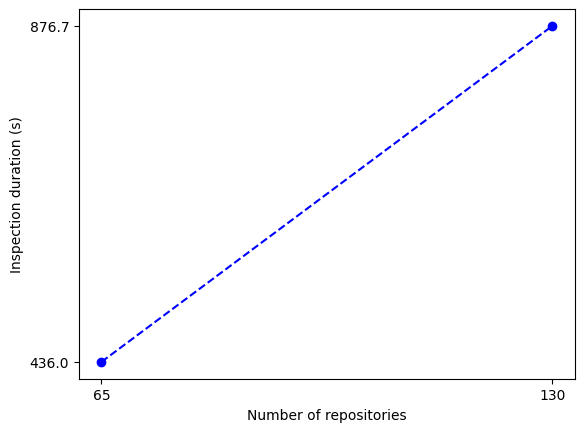

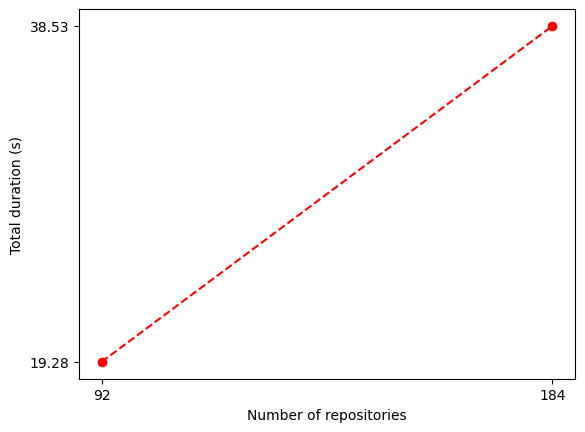

In [34]:
import matplotlib.pyplot as plt

checkov_timing_count = [
    len(checkov_df),
    2*len(checkov_df),
]
checkov_timing_duration = [
    checkov_df.select(
        duration=pl.col('before').list.get(0).struct.field('duration')
    ).sum().item(),
    checkov_df.select(
        duration=pl.col('before').list.get(0).struct.field('duration') + pl.col('after').struct.field('duration')
    ).sum().item()
]

tflint_timing_count = [
    len(tflint_df),
    2*len(tflint_df),
]
tflint_timing_duration = [
    tflint_df.select(
        duration=pl.col('before').list.get(0).struct.field('duration')
    ).sum().item(),
    tflint_df.select(
        duration=pl.col('before').list.get(0).struct.field('duration') + pl.col('after').struct.field('duration')
    ).sum().item()
]

_, ax1 = plt.subplots()
ax1.set_xlabel('Number of repositories')
ax1.set_ylabel('Inspection duration (s)')
ax1.set_xticks(checkov_timing_count)
ax1.set_yticks(checkov_timing_duration)
ax1.plot(checkov_timing_count, checkov_timing_duration, 'bo--')

_, ax2 = plt.subplots()
ax2.set_xlabel('Number of repositories')
ax2.set_ylabel('Total duration (s)')
ax2.set_xticks(tflint_timing_count)
ax2.set_yticks(tflint_timing_duration)
ax2.plot(tflint_timing_count, tflint_timing_duration, 'ro--')